# 2. Frame Extraction

In [11]:
import cv2
import os

def extract_frames(video_path, output_dir, frame_rate=1):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    if not video.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    fps = video.get(cv2.CAP_PROP_FPS)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    
    print(f"Video FPS: {fps}")
    print(f"Total frames: {total_frames}")
    print(f"Duration: {duration:.2f} seconds")
    
    # Initialize frame counter
    count = 0
    frame_count = 0
    
    # Read until video is completed
    while True:
        ret, frame = video.read()
        
        # Break the loop if we have reached the end of the video
        if not ret:
            break
        
        # Save frame at the specified interval
        if count % 1 == 0:
            frame_filename = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"Extracted: {frame_filename}")
            frame_count += 1
        
        count += 1
    
    # Release the video capture object
    video.release()
    
    print(f"Extraction complete. {frame_count} frames extracted to {output_dir}")

def get_file_paths():
    file_paths = []

    for root, dirs, files in os.walk("videos"):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    return file_paths

if not os.path.isdir('frames'): # If it exists, it was done already so do not run
    file_paths = get_file_paths()

    for file_path in file_paths:
        extract_frames(file_path, os.path.join("frames", os.path.basename(file_path)))
else :
    print("Frames had already been extracted, skipping...")

Frames had already been extracted, skipping...


# 3. Feature Detection and Description

In [12]:
import time

#feature detection using ORB, SIFT, and BRISK
# Keeping the original function signatures as requested
def load_images_from_all_videos(base_folder, max_images_per_video=10):
    """Loads images from all video subfolders (limited per folder)."""
    # This function will still load from all subfolders for compatibility,
    # but the processing loop below will handle per-video logic.
    all_images = []
    video_folders = sorted(os.listdir(base_folder))

    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    for video_folder in video_folders:
        full_path = os.path.join(base_folder, video_folder)
        if not os.path.isdir(full_path):
            continue  # skip non-folder entries

        image_filenames = sorted(os.listdir(full_path))
        image_files = [f for f in image_filenames if os.path.splitext(f)[1].lower() in image_extensions]

        for filename in image_files[:max_images_per_video]:
            img_path = os.path.join(full_path, filename)
            img_color = cv2.imread(img_path)
            if img_color is None:
                print(f"Warning: Couldn't read {img_path}")
                continue
            img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
            # Store video_folder name with the image data
            all_images.append((video_folder, filename, img_color, img_gray))

    return all_images

#detect features using ORB, SIFT, and BRISK
def detect_features(detector, images_for_one_video, use_gray=True):
    """Detects features for a list of images belonging to ONE video."""
    results = []
    for video_folder, filename, img_color, img_gray in images_for_one_video:
        img = img_gray if use_gray else img_color
        start_time = time.time()
        keypoints, descriptors = detector.detectAndCompute(img, None)
        time_taken = time.time() - start_time
        results.append({
            'video_folder': video_folder, # Retain video folder information
            'filename': filename,
            'image': img_color,
            'keypoints': keypoints,
            'descriptors': descriptors,
            'time': time_taken
        })
    return results

#draw keypoints on images
def draw_keypoints(results_for_one_video, alg_name, base_output_dir="output_keypoints"):
    """Draws keypoints for results from ONE video."""
    if not results_for_one_video:
        return # Nothing to draw

    # Create output directory structure: base_output_dir / video_folder
    video_folder = results_for_one_video[0]['video_folder']
    output_dir = os.path.join(base_output_dir, alg_name, video_folder) # Organize by Algorithm then Video

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Drawing {alg_name} keypoints for video: {video_folder}")
    for res in results_for_one_video:
        img_with_kp = cv2.drawKeypoints(res['image'], res['keypoints'], None, color=(0, 255, 0))
        # Save file as original_filename_with_kp.jpg inside the video's output folder
        out_filename = os.path.splitext(res['filename'])[0] + "_with_kp.jpg"
        out_path = os.path.join(output_dir, out_filename)
        cv2.imwrite(out_path, img_with_kp)
        # print(f"Saved: {out_path}") # Suppressed print for cleaner output

#analyze results
def analysis(results_for_one_video, alg_name, video_folder):
    """Analyzes results for images from ONE video."""
    print(f"\n - - {alg_name} Analysis for Video: {video_folder} - -")
    total_kps = 0
    total_time = 0

    if not results_for_one_video:
        print("No images processed for this video.")
        return

    #print summary of results per image in this video
    for res in results_for_one_video:
        print(f"{res['filename']}: {len(res['keypoints'])} keypoints in {res['time']:.4f}s")
        total_kps += len(res['keypoints'])
        total_time += res['time']

    avg_kps = total_kps / len(results_for_one_video)
    avg_time = total_time / len(results_for_one_video)
    print(f"Average keypoints per image in {video_folder}: {avg_kps:.2f} | Average Time per image: {avg_time:.4f}s")


# --- Execution for Code Block 2 ---
frame_dir = "frames"  #path to frames
video_folders = sorted([d for d in os.listdir(frame_dir) if os.path.isdir(os.path.join(frame_dir, d))])

if not video_folders:
    print(f"No video subfolders found in '{frame_dir}'. Please run Block 1 first.")
else:
    print(f"Processing feature detection for {len(video_folders)} videos...")

    # Initialize detectors once
    orb = cv2.ORB_create(nfeatures=1000)
    sift = cv2.SIFT_create()
    brisk = cv2.BRISK_create()
    detectors = {"ORB": orb, "SIFT": sift, "BRISK": brisk}

    # Process each video folder separately
    for video_folder in video_folders:
        video_path = os.path.join(frame_dir, video_folder)
        print(f"\n--- Processing video: {video_folder} ---")

        # Load images specifically for this video folder
        images_for_one_video = []
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = sorted([f for f in os.listdir(video_path) if os.path.splitext(f)[1].lower() in image_extensions])

        max_images_per_video = 10 # Define the limit per video here as well
        for filename in image_files[:max_images_per_video]:
             img_path = os.path.join(video_path, filename)
             img_color = cv2.imread(img_path)
             if img_color is None:
                 print(f"Warning: Couldn't read {img_path}")
                 continue
             img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
             images_for_one_video.append((video_folder, filename, img_color, img_gray)) # Store with video folder name

        if not images_for_one_video:
            print(f"No images found in {video_folder}. Skipping feature detection for this video.")
            continue

        # Detect features, draw, and analyze for THIS video
        for alg_name, detector in detectors.items():
            print(f"\nRunning {alg_name} detector for {video_folder}...")
            results_for_one_video = detect_features(detector, images_for_one_video)

            # Save keypoint visualizations for this video/algorithm if output dir doesn't exist
            # Check if the specific video/algorithm output folder exists
            video_alg_output_dir = os.path.join("output_keypoints", alg_name, video_folder)
            if not os.path.exists(video_alg_output_dir):
                 draw_keypoints(results_for_one_video, alg_name, base_output_dir="output_keypoints")
            else:
                 print(f"Keypoint visualizations for {alg_name}/{video_folder} already exist, skipping drawing.")


            # Analyze results for this video/algorithm
            analysis(results_for_one_video, alg_name, video_folder)

    print("\nFeature detection and analysis complete for all videos.")

Processing feature detection for 5 videos...

--- Processing video: Vid1.mp4 ---

Running ORB detector for Vid1.mp4...
Keypoint visualizations for ORB/Vid1.mp4 already exist, skipping drawing.

 - - ORB Analysis for Video: Vid1.mp4 - -
frame_0000.jpg: 976 keypoints in 0.0115s
frame_0001.jpg: 977 keypoints in 0.0045s
frame_0002.jpg: 976 keypoints in 0.0046s
frame_0003.jpg: 976 keypoints in 0.0048s
frame_0004.jpg: 977 keypoints in 0.0043s
frame_0005.jpg: 983 keypoints in 0.0044s
frame_0006.jpg: 985 keypoints in 0.0044s
frame_0007.jpg: 985 keypoints in 0.0044s
frame_0008.jpg: 980 keypoints in 0.0044s
frame_0009.jpg: 980 keypoints in 0.0044s
Average keypoints per image in Vid1.mp4: 979.50 | Average Time per image: 0.0052s

Running SIFT detector for Vid1.mp4...
Keypoint visualizations for SIFT/Vid1.mp4 already exist, skipping drawing.

 - - SIFT Analysis for Video: Vid1.mp4 - -
frame_0000.jpg: 312 keypoints in 0.0453s
frame_0001.jpg: 321 keypoints in 0.0810s
frame_0002.jpg: 337 keypoints in

# 4/5. Feature Matching and Outlier Rejection + Fundamental Matrix Computation

In [13]:
import matplotlib.pyplot as plt
import numpy as np

#load images from all videos
def load_image_pairs(folder_path, step=1, max_pairs=3):
    """Loads image pairs from a SINGLE video folder."""
    pairs = []
    filenames = sorted([f for f in os.listdir(folder_path) if f.endswith((".jpg", ".jpeg", ".png"))])
    num_pairs = min(len(filenames) - step, max_pairs)

    for i in range(num_pairs):
        img1_filename = filenames[i]
        img2_filename = filenames[i + step]
        img1_path = os.path.join(folder_path, img1_filename)
        img2_path = os.path.join(folder_path, img2_filename)

        img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

        if img1 is not None and img2 is not None:
            # Store full path or relevant info to reconstruct later if needed
            # For now, store just the filenames within the video folder context
            video_folder_name = os.path.basename(folder_path)
            pairs.append((video_folder_name, img1_filename, img2_filename, img1, img2))
        else:
            print(f"Warning: Couldn't load pair {img1_path}, {img2_path}")
    return pairs

#get feature detector (No change)
def get_detector(name="SIFT"):
    if name == "ORB":
        return cv2.ORB_create(nfeatures=1000)
    elif name == "BRISK":
        return cv2.BRISK_create()
    else:
        return cv2.SIFT_create()

#get matcher based on descriptor type (No change)
def get_matcher(desc_type):
    if desc_type == "float":
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        return cv2.FlannBasedMatcher(index_params, search_params)
    else:
        return cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

#match features between two images (No change)
def match_features(detector, img1, img2):
    kp1, des1 = detector.detectAndCompute(img1, None)
    kp2, des2 = detector.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        # print("Warning: Descriptors are None.") # Debug print
        return kp1, kp2, []

    #check descriptor type
    desc_type = "float" if des1.dtype == np.float32 else "binary"
    matcher = get_matcher(desc_type)

    matches = []
    try:
        if desc_type == "float":
            raw_matches = matcher.knnMatch(des1, des2, k=2)
            good_matches = []
            for m, n in raw_matches:
                if m.distance < 0.75 * n.distance: # Ratio test
                    good_matches.append(m)
            matches = good_matches
        else: # Binary descriptors (ORB, BRISK)
            matches = matcher.match(des1, des2)
            # Optionally sort for BFMatcher, though crossCheck helps filter already
            matches = sorted(matches, key=lambda x: x.distance)
    except cv2.error as e:
        print(f"Matching error: {e}")
        matches = [] # Ensure matches is an empty list on error


    return kp1, kp2, matches

#ransac filter to remove outliers (No change)
def ransac_filter(kp1, kp2, matches):
    # Need at least 4 points for findFundamentalMat with RANSAC, but 8 is safer
    if len(matches) < 8:
        # print(f"Warning: Not enough matches ({len(matches)}) for RANSAC.") # Debug print
        return [], None

    #extract location of good matches
    try:
        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # Use RANSAC to find the Fundamental Matrix and inliers
        # Default RANSAC parameters are usually fine
        F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC)

        if mask is None: # Should not happen with RANSAC, but good practice
             print("Warning: RANSAC mask is None.")
             return [], F

        # Apply the mask to filter inliers
        inliers = [m for i, m in enumerate(matches) if mask[i]]

    except cv2.error as e:
        print(f"RANSAC error: {e}")
        return [], None # Return empty list and None F on error

    return inliers, F

#draw matches between two images (Modified to include video/pair context)
def draw_matches(img1, kp1, img2, kp2, matches, video_folder, img1_filename, img2_filename, match_type, base_out_folder="output_matches"):
    """Draws matches for a specific pair from a specific video."""
    # Create output directory structure: base_out_folder / video_folder / match_type
    output_dir = os.path.join(base_out_folder, video_folder, match_type.replace(" ", "_").lower())

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Determine if images are grayscale or color for drawing
    is_gray = (len(img1.shape) == 2)

    # Convert grayscale images to color for drawing if needed
    img1_display = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) if is_gray else img1
    img2_display = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if is_gray else img2


    #draw matches
    # Use plot=None to return the image array, then save with cv2.imwrite
    matched_img = cv2.drawMatches(img1_display, kp1, img2_display, kp2, matches, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    # Create a descriptive filename
    # Use parts of original filenames to make output filename unique and informative
    name1_base = os.path.splitext(img1_filename)[0]
    name2_base = os.path.splitext(img2_filename)[0]
    out_filename = f"{name1_base}_vs_{name2_base}_{match_type.replace(' ', '_').lower()}.png"
    out_path = os.path.join(output_dir, out_filename)

    # Save the image using cv2.imwrite as it handles color spaces better than plt.savefig in this context
    cv2.imwrite(out_path, matched_img)
    # print(f"Saved match visualization: {out_path}") # Suppressed print

# --- Execution for Code Block 3 ---
frame_dir = "frames"
detector_name = "SIFT" # Can change detector here
detector = get_detector(detector_name)

# List to store results for ALL pairs across ALL videos
all_pair_processing_results = []

video_folders = sorted([d for d in os.listdir(frame_dir) if os.path.isdir(os.path.join(frame_dir, d))])

if not video_folders:
    print(f"No video subfolders found in '{frame_dir}'. Please run Block 1 first.")
else:
    print(f"Processing feature matching for {len(video_folders)} videos...")

    # Process each video folder separately
    for video_folder in video_folders:
        video_path = os.path.join(frame_dir, video_folder)
        print(f"\n--- Processing matching for video: {video_folder} ---")

        # Load pairs specifically for this video folder
        pairs_for_one_video = load_image_pairs(video_path, step=1, max_pairs=3)

        if not pairs_for_one_video:
            print(f"No image pairs found in {video_folder}. Skipping matching for this video.")
            continue

        # Process each pair within this video
        for video_folder_name, fname1, fname2, img1, img2 in pairs_for_one_video:
             print(f"  Processing pair: {fname1} & {fname2}")

             # Perform matching
             kp1, kp2, matches = match_features(detector, img1, img2)
             print(f"    Total matches before RANSAC: {len(matches)}")

             # Draw and save matches before RANSAC
             # Check if the output directory for this video/match_type exists before drawing
             pre_ransac_output_dir = os.path.join("output_matches", video_folder, "before_ransac")
             if not os.path.exists(pre_ransac_output_dir):
                 draw_matches(img1, kp1, img2, kp2, matches, video_folder, fname1, fname2, "Before RANSAC")
             else:
                 # print("    Before RANSAC visualizations already exist, skipping drawing.") # Suppress for cleaner output
                 pass


             # Perform RANSAC filtering
             inliers, F = ransac_filter(kp1, kp2, matches)
             print(f"    Matches after RANSAC: {len(inliers)}")

             # Draw and save matches after RANSAC
             # Check if the output directory for this video/match_type exists before drawing
             post_ransac_output_dir = os.path.join("output_matches", video_folder, "after_ransac")
             if not os.path.exists(post_ransac_output_dir):
                 draw_matches(img1, kp1, img2, kp2, inliers, video_folder, fname1, fname2, "After RANSAC")
             else:
                 # print("    After RANSAC visualizations already exist, skipping drawing.") # Suppress for cleaner output
                 pass

             # Store results for this pair
             if inliers: # Only store if RANSAC found inliers
                 all_pair_processing_results.append({
                     'video_folder': video_folder,
                     'fname1': fname1,
                     'fname2': fname2,
                     'kp1': kp1,
                     'kp2': kp2,
                     'inliers': inliers,
                     'F': F
                 })
             else:
                  print(f"    No inliers found for pair {fname1} & {fname2}. Skipping pose estimation for this pair.")


    print("\nFeature matching and RANSAC complete for all videos.")
    # The list all_pair_processing_results is now available for the next block

Processing feature matching for 5 videos...

--- Processing matching for video: Vid1.mp4 ---
  Processing pair: frame_0000.jpg & frame_0001.jpg
    Total matches before RANSAC: 240
    Matches after RANSAC: 231
  Processing pair: frame_0001.jpg & frame_0002.jpg
    Total matches before RANSAC: 230
    Matches after RANSAC: 227
  Processing pair: frame_0002.jpg & frame_0003.jpg
    Total matches before RANSAC: 247
    Matches after RANSAC: 241

--- Processing matching for video: Vid2.mp4 ---
  Processing pair: frame_0000.jpg & frame_0001.jpg
    Total matches before RANSAC: 154
    Matches after RANSAC: 150
  Processing pair: frame_0001.jpg & frame_0002.jpg
    Total matches before RANSAC: 155
    Matches after RANSAC: 151
  Processing pair: frame_0002.jpg & frame_0003.jpg
    Total matches before RANSAC: 159
    Matches after RANSAC: 151

--- Processing matching for video: Vid3.mp4 ---
  Processing pair: frame_0000.jpg & frame_0001.jpg
    Total matches before RANSAC: 246
    Matches a

As required by the assignment, this section explains the underlying calculations involved in computing the fundamental matrix and clarifies the distinction between calibrated and uncalibrated cameras.

#### 5a. Understanding Underlying Calculations for Fundamental Matrix Computation

When computing the fundamental matrix ($F$) using a function like OpenCV's `cv.findFundamentalMat()`, the process relies on the epipolar constraint, which states that for any pair of corresponding points $p_1$ in the first image and $p_2$ in the second image, the following relationship holds:

$$p_2^T F p_1 = 0$$

Here, $p_1$ and $p_2$ are the homogeneous coordinates of the points. The fundamental matrix is a $3 \times 3$ matrix that encapsulates the epipolar geometry between the two uncalibrated views.

The fundamental matrix has 9 elements but is determined up to a scale factor, giving 8 degrees of freedom. Additionally, it must satisfy the rank constraint $det(F) = 0$.

A common method for estimating the fundamental matrix is the **Eight-Point Algorithm**. This algorithm uses at least 8 pairs of corresponding points to set up a system of linear equations in the elements of $F$. Each corresponding point pair $(p_{1i}, p_{2i})$ contributes one linear equation based on the epipolar constraint. If we stack the elements of $F$ into a vector $f$, we get a system of equations $Af = 0$, where $A$ is a matrix derived from the point coordinates. This system can be solved for $f$ (and thus $F$) using methods like Singular Value Decomposition (SVD).

The linear estimate of $F$ from the 8-point algorithm may not satisfy the rank-2 constraint. To enforce this, SVD is typically applied to the estimated $F = U \Sigma V^T$. We then set the smallest singular value in $\Sigma$ to zero to produce $\Sigma'$, resulting in the rank-2 fundamental matrix $F' = U \Sigma' V^T$.

In the presence of outliers (incorrect matches), a robust estimation method like **RANSAC (Random Sample Consensus)** is employed. When you use `cv.findFundamentalMat()` with the `cv2.RANSAC` method, OpenCV is internally implementing a RANSAC-based approach. RANSAC iteratively:
1.  Selects a minimal set of 8 point correspondences.
2.  Computes a candidate fundamental matrix using these points.
3.  Counts how many of the *remaining* points are consistent with this matrix (inliers).
4.  Repeats this process many times and chooses the matrix with the largest number of inliers.
5.  Optionally, re-estimates the matrix using all identified inliers.

This robust estimation is crucial for obtaining an accurate fundamental matrix from noisy real-world data.

#### 5b. Difference Between Calibrated and Uncalibrated Cameras

The choice of computing the essential matrix ($E$) or the fundamental matrix ($F$) depends on whether your cameras are calibrated.

* **Uncalibrated Cameras:**
    * **Definition:** Cameras for which the intrinsic parameters (focal length, principal point, distortion coefficients) are **unknown**.
    * **Matrix:** The **Fundamental Matrix ($F$)** is used.
    * **Coordinates:** $F$ relates corresponding points in **image coordinates (pixels)**.
    * **Purpose:** Describes the epipolar geometry (relationship between points and epipolar lines) in the image plane. It can be used to verify point correspondences and find epipolar lines.
    * **Limitation:** Without knowing the intrinsic parameters, $F$ does not encode metric information about the scene or the cameras' 3D motion.

* **Calibrated Cameras:**
    * **Definition:** Cameras for which the intrinsic parameters are **known** (usually determined through a camera calibration procedure).
    * **Matrix:** The **Essential Matrix ($E$)** is used.
    * **Coordinates:** $E$ relates corresponding points in **normalized image coordinates**. These coordinates are obtained by removing the effect of intrinsic parameters (e.g., by multiplying image coordinates by the inverse of the camera intrinsic matrix, $K^{-1}$).
    * **Relationship:** The essential matrix is related to the fundamental matrix by the camera intrinsic matrices $K_1$ and $K_2$: $E = K_2^T F K_1$.
    * **Purpose:** Describes the epipolar geometry in a normalized coordinate system and crucially encodes the **relative rotation and translation** between the two camera views.
    * **Advantage:** Knowing the intrinsic parameters and having the essential matrix allows for the recovery of the camera's relative 3D pose and enables metric 3D reconstruction of the scene.

In the context of this assignment, the videos were taken using an uncalibrated mobile phone camera. Therefore the fundamental matrix was computed and not the essential matrix.

# 6. Camera Position Estimation

In [14]:
# Code block 4 (Modified to store R and t in results)
import numpy as np
import cv2 # Ensure cv2 is imported

# --- Placeholder Camera Matrix ---
pixel_focal_length = 4500
image_width = 478
image_height = 850

# Principal point assumed at the image center
principal_point_x = image_width / 2
principal_point_y = image_height / 2

camera_matrix = np.array([[pixel_focal_length, 0, principal_point_x], [0, pixel_focal_length, principal_point_y], [0, 0, 1]], dtype=np.float32)

print("Using Placeholder Camera Matrix:")
print(camera_matrix)

# --- Execution for Code Block 4 ---
# This block assumes 'all_pair_processing_results' list is available from Block 3

if 'all_pair_processing_results' not in locals() or not all_pair_processing_results:
    print("\nNo pair processing results found from Block 3.")
    print("Please run Block 3 first and ensure it generated results with inliers.")
else:
    print(f"\nProcessing pose estimation for {len(all_pair_processing_results)} pairs...")

    # Iterate through the results collected from each pair in Block 3
    # We iterate using index so we can modify the list item directly
    for i in range(len(all_pair_processing_results)):
        pair_result = all_pair_processing_results[i] # Get the dictionary for the current pair

        video_folder = pair_result['video_folder']
        fname1 = pair_result['fname1']
        fname2 = pair_result['fname2']
        kp1 = pair_result['kp1']
        kp2 = pair_result['kp2']
        inliers = pair_result['inliers']
        F = pair_result['F'] # Fundamental Matrix from RANSAC

        print(f"\n--- Estimating Pose for Video: {video_folder}, Pair: {fname1} & {fname2} ---")

        # Check if we have enough inliers for pose estimation
        # recoverPose using F typically needs at least 8 points (like findFundamentalMat)
        if len(inliers) < 8:
            print(f"  Not enough inliers ({len(inliers)}) for reliable pose estimation. Skipping this pair.")
            # Optionally mark this pair as skipped or remove it if R, t are critical
            # For now, we just skip calculating R,t but the pair is still in the list
            continue

        # Extract points from inlier matches
        try:
            pts1 = np.float32([kp1[m.queryIdx].pt for m in inliers]).reshape(-1, 1, 2)
            pts2 = np.float32([kp2[m.trainIdx].pt for m in inliers]).reshape(-1, 1, 2)

            # Estimate camera pose using recoverPose
            ret, R, t, mask = cv2.recoverPose(F, pts1, pts2, camera_matrix)

            print(f"  Number of points successfully reconstructed in front of both cameras: {ret}")
            print("\n  Estimated Rotation Matrix (R):")
            print(R)
            print("\n  Estimated Translation Vector (t):")
            print(t.flatten())

            # --- IMPORTANT MODIFICATION ---
            # Store the calculated R and t back into the pair_result dictionary
            all_pair_processing_results[i]['R'] = R
            all_pair_processing_results[i]['t'] = t
            print(f"  Stored R and t for pair {fname1} & {fname2}.")
            # --- END OF IMPORTANT MODIFICATION ---


        except cv2.error as e:
             print(f"  Error during cv2.recoverPose for pair {fname1} & {fname2}: {e}")
             # Optionally, handle error by marking this pair's results as invalid or incomplete
        except Exception as e:
             print(f"  An unexpected error occurred during pose estimation for pair {fname1} & {fname2}: {e}")


    print("\nPose estimation complete for all processed pairs.")
    # all_pair_processing_results now contains R and t for pairs where estimation was successful

Using Placeholder Camera Matrix:
[[4.50e+03 0.00e+00 2.39e+02]
 [0.00e+00 4.50e+03 4.25e+02]
 [0.00e+00 0.00e+00 1.00e+00]]

Processing pose estimation for 15 pairs...

--- Estimating Pose for Video: Vid1.mp4, Pair: frame_0000.jpg & frame_0001.jpg ---
  Number of points successfully reconstructed in front of both cameras: 115

  Estimated Rotation Matrix (R):
[[ 0.97013142  0.1144796  -0.21386785]
 [ 0.1135155   0.56491035  0.81730687]
 [ 0.21438112 -0.81717239  0.53504207]]

  Estimated Translation Vector (t):
[0.96699179 0.25478921 0.00305543]
  Stored R and t for pair frame_0000.jpg & frame_0001.jpg.

--- Estimating Pose for Video: Vid1.mp4, Pair: frame_0001.jpg & frame_0002.jpg ---
  Number of points successfully reconstructed in front of both cameras: 127

  Estimated Rotation Matrix (R):
[[ 0.76467814  0.04930384  0.64252352]
 [ 0.04869578  0.98979698 -0.13390544]
 [-0.64256989  0.13368275  0.75447522]]

  Estimated Translation Vector (t):
[0.20513612 0.97872874 0.00303832]
  Sto

# 7. 3D Point Triangulation and Scene Visualisation

Using camera_matrix defined in previous block.

Performing triangulation for 15 pairs with inliers...

--- Triangulating points for Video: Vid1.mp4, Pair: frame_0000.jpg & frame_0001.jpg ---
  Triangulated 231 3D points.

--- Triangulating points for Video: Vid1.mp4, Pair: frame_0001.jpg & frame_0002.jpg ---
  Triangulated 227 3D points.

--- Triangulating points for Video: Vid1.mp4, Pair: frame_0002.jpg & frame_0003.jpg ---
  Triangulated 241 3D points.

--- Triangulating points for Video: Vid2.mp4, Pair: frame_0000.jpg & frame_0001.jpg ---
  Triangulated 150 3D points.

--- Triangulating points for Video: Vid2.mp4, Pair: frame_0001.jpg & frame_0002.jpg ---
  Triangulated 151 3D points.

--- Triangulating points for Video: Vid2.mp4, Pair: frame_0002.jpg & frame_0003.jpg ---
  Triangulated 151 3D points.

--- Triangulating points for Video: Vid3.mp4, Pair: frame_0000.jpg & frame_0001.jpg ---
  Triangulated 243 3D points.

--- Triangulating points for Video: Vid3.mp4, Pair: frame_0001.j

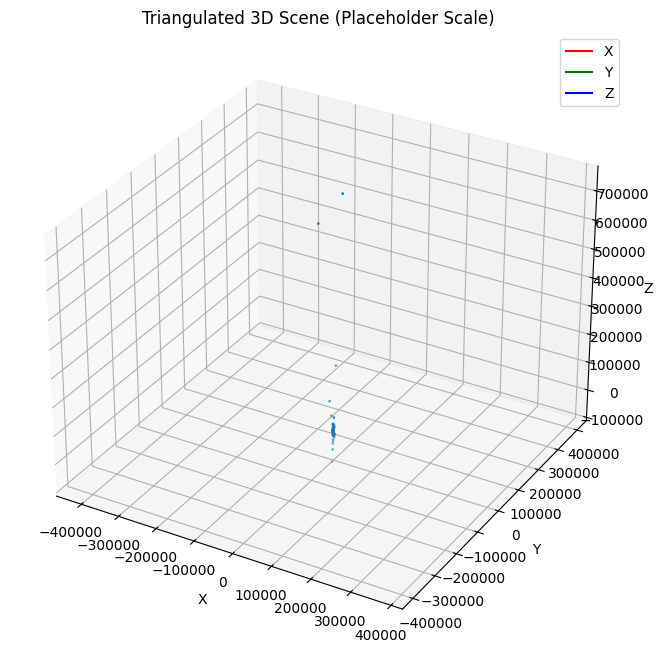

In [15]:
# Code block 5: 3D Point Triangulation and Scene Visualization (using Matplotlib interactive features)
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Ensure you have a Matplotlib backend installed that supports interactive plots (e.g., pip install PyQt5 or pip install Tkinter)
# import open3d as o3d # Open3D is not used in this version
import os

# --- Assume camera_matrix is available from previous block (Block 4) ---
try:
    _ = camera_matrix
    print("Using camera_matrix defined in previous block.")
except NameError:
    print("camera_matrix not found, using placeholder defined in this block.")
    pixel_focal_length = 4500
    image_width = 478
    image_height = 850
    principal_point_x = image_width / 2
    principal_point_y = image_height / 2
    camera_matrix = np.array([[pixel_focal_length, 0, principal_point_x], [0, pixel_focal_length, principal_point_y], [0, 0, 1]], dtype=np.float32)
    print("Placeholder Camera Matrix:")
    print(camera_matrix)


# --- Triangulation and Visualization ---

all_triangulated_points = []

if 'all_pair_processing_results' not in locals() or not all_pair_processing_results:
    print("\nNo pair processing results found from Block 3.")
    print("Please run Block 3 first and ensure it generated results with inliers.")
else:
    print(f"\nPerforming triangulation for {len(all_pair_processing_results)} pairs with inliers...")

    for pair_result in all_pair_processing_results:
        video_folder = pair_result['video_folder']
        fname1 = pair_result['fname1']
        fname2 = pair_result['fname2']
        kp1 = pair_result['kp1']
        kp2 = pair_result['kp2']
        inliers = pair_result['inliers']
        F = pair_result['F']

        print(f"\n--- Triangulating points for Video: {video_folder}, Pair: {fname1} & {fname2} ---")

        if len(inliers) < 8:
            print(f"  Not enough inliers ({len(inliers)}) for triangulation. Skipping this pair.")
            continue

        pts1 = np.float32([kp1[m.queryIdx].pt for m in inliers]).reshape(-1, 1, 2)
        pts2 = np.float32([kp2[m.trainIdx].pt for m in inliers]).reshape(-1, 1, 2)

        # Get Camera Projection Matrices
        R1 = np.eye(3)
        t1 = np.zeros((3, 1))
        P1 = camera_matrix @ np.hstack((R1, t1))

        # Access R and t for this pair from the stored results (Requires Modified Block 4)
        if 'R' not in pair_result or 't' not in pair_result:
             print(f"  Warning: R or t not found in results for pair {fname1} & {fname2}. Skipping triangulation.")
             continue

        R2 = pair_result['R']
        t2 = pair_result['t']

        P2 = camera_matrix @ np.hstack((R2, t2))

        # Perform Triangulation (returns 4xN homogeneous points)
        try:
            points_4d_homogeneous = cv2.triangulatePoints(P1, P2, pts1, pts2)

            # Convert from homogeneous to non-homogeneous coordinates (3D points - Nx3)
            points_3d = (points_4d_homogeneous[:3, :] / points_4d_homogeneous[3, :]).T

            print(f"  Triangulated {points_3d.shape[0]} 3D points.")

            all_triangulated_points.extend(points_3d)

        except cv2.error as e:
            print(f"  Error during cv2.triangulatePoints for pair {fname1} & {fname2}: {e}")
        except Exception as e:
            print(f"  An unexpected error occurred during triangulation for pair {fname1} & {fname2}: {e}")


    # --- Visualization using Matplotlib ---
    if not all_triangulated_points:
        print("\nNo 3D points were triangulated from any pair.")
    else:
        print(f"\nVisualizing a total of {len(all_triangulated_points)} triangulated 3D points using Matplotlib...")

        all_triangulated_points = np.array(all_triangulated_points)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(all_triangulated_points[:, 0], all_triangulated_points[:, 1], all_triangulated_points[:, 2], s=1)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Triangulated 3D Scene (Placeholder Scale)')

        # Set equal aspect ratio for better 3D perspective
        max_range = np.array([all_triangulated_points[:,0].max()-all_triangulated_points[:,0].min(),
                              all_triangulated_points[:,1].max()-all_triangulated_points[:,1].min(),
                              all_triangulated_points[:,2].max()-all_triangulated_points[:,2].min()]).max() / 2.0

        mid_x = (all_triangulated_points[:,0].max()+all_triangulated_points[:,0].min()) * 0.5
        mid_y = (all_triangulated_points[:,1].max()+all_triangulated_points[:,1].min()) * 0.5
        mid_z = (all_triangulated_points[:,2].max()+all_triangulated_points[:,2].min()) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        # Optional: Add coordinate system origin axes
        ax.quiver(0, 0, 0, 1, 0, 0, color='r', label='X')
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', label='Y')
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', label='Z')
        ax.legend()

        # Display the plot window for interaction
        plt.show()